In [32]:
from preprocess import get_prepared_data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report

In [ ]:
X, y = get_prepared_data(oversample=False, relabel=False)
X = X.reshape(X.shape[0], X.shape[1], 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [ ]:
from preprocess import get_prepared_data
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report

In [ ]:


# 1. Wczytanie danych
df = pd.read_csv("/home/lidia/neurohackathon/data/Epileptic_Seizure_Recognition.csv",)  # Zmień na właściwą ścieżkę pliku

# 2. Przygotowanie danych
X = df.iloc[:, 1:-1].values  # Pomijamy pierwszą kolumnę (identyfikator) i ostatnią (etykieta)
y = df.iloc[:, -1].values

# 3. Normalizacja
# tested also RobustScaler and MinMaxScaler but with no positive effect on the results
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
#X_scaled = X

# 4. Zmiana kształtu na (n_samples, 178, 1)
X_reshaped = X_scaled.reshape(X_scaled.shape[0], X_scaled.shape[1], 1)

# 5. Podział na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y, test_size=0.2, random_state=42, stratify=y)



Accuracy: 0.18050065876152832
Precision: 0.13020713628384847
Recall: 0.18050065876152832

Classification Report:
               precision    recall  f1-score   support

           1       0.17      0.38      0.23       456
           2       0.00      0.00      0.00       455
           3       0.21      0.42      0.28       455
           4       0.12      0.03      0.05       456
           5       0.15      0.08      0.10       455

    accuracy                           0.18      2277
   macro avg       0.13      0.18      0.13      2277
weighted avg       0.13      0.18      0.13      2277


[[171   4 155  58  68]
 [217   0 172  18  48]
 [202   0 190   9  54]
 [217   0 178  13  48]
 [222   0 190   6  37]]


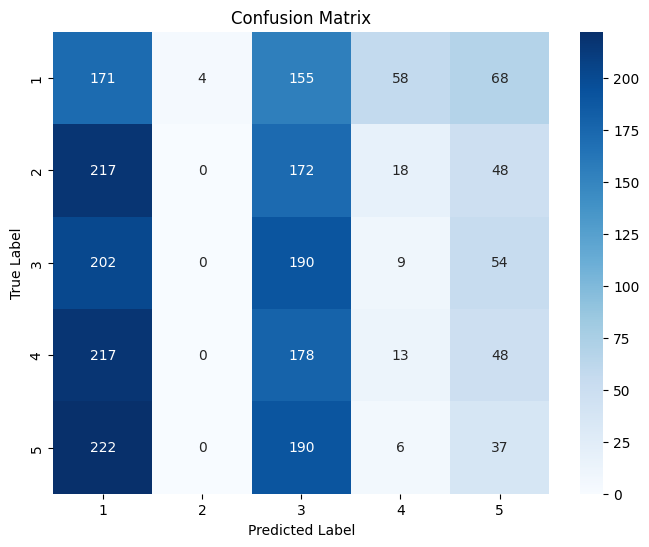

In [35]:

class ImprovedShapeletClassifier:
    def __init__(self, n_shapelets=10):
        """
        Inicjalizacja klasyfikatora Shapeletów.
        
        :param n_shapelets: Liczba Shapeletów.
        """
        self.n_shapelets = n_shapelets
        self.shapelets = None
        self.shapelet_labels = None
        self.classes_ = None

    def fit(self, X, y):
        """
        Trenuje klasyfikator, wybierając Shapelety i przypisując im klasy.
        
        :param X: Dane treningowe w kształcie (n_samples, series_length, 1).
        :param y: Etykiety w kształcie (n_samples,).
        """
        np.random.seed(42)
        self.classes_ = np.unique(y)
        n_samples, series_length, _ = X.shape
        
        # Wybór Shapeletów losowo
        shapelet_indices = np.random.choice(n_samples, self.n_shapelets, replace=False)
        self.shapelets = X[shapelet_indices]
        
        # Przypisanie etykiet Shapeletom na podstawie najbliższych próbek
        self.shapelet_labels = y[shapelet_indices]

    def _distance_to_shapelet(self, X, shapelet):
        """
        Oblicza minimalną odległość między Shapeletem a próbką czasową.
        
        :param X: Próbka w kształcie (series_length, 1).
        :param shapelet: Shapelet w kształcie (series_length, 1).
        :return: Odległość do Shapeleta.
        """
        # Odległość euklidesowa między Shapeletem a fragmentami serii czasowej
        distances = np.sqrt(np.sum((X - shapelet) ** 2, axis=1))
        return np.min(distances)

    def predict(self, X):
        """
        Dokonuje predykcji na podstawie dopasowania Shapeletów.
        
        :param X: Dane testowe w kształcie (n_samples, series_length, 1).
        :return: Predykcje w kształcie (n_samples,).
        """
        n_samples, series_length, _ = X.shape
        predictions = []

        for sample in X:
            # Oblicz odległość każdej próbki do każdego Shapeleta
            distances = [self._distance_to_shapelet(sample, shapelet) for shapelet in self.shapelets]
            
            # Znajdź Shapeleta o minimalnej odległości
            closest_shapelet_idx = np.argmin(distances)
            predictions.append(self.shapelet_labels[closest_shapelet_idx])

        return np.array(predictions)


# 1. Inicjalizacja klasyfikatora
shapelet_clf = ImprovedShapeletClassifier(n_shapelets=50)

# 2. Trening klasyfikatora
shapelet_clf.fit(X_train, y_train)

# 3. Predykcja
y_pred = shapelet_clf.predict(X_test)

# 4. Ewaluacja wyników
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print()
print(conf_matrix)

# 5. Wizualizacja confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=shapelet_clf.classes_, yticklabels=shapelet_clf.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()
